# Introduction

In this experiment we will use a dataset that is generated with a common standard sampling rate $f_s$. The goal is to see if and which architectures of neural networks are able to learn bandlimited signals.

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from samprecon.reconstructors.perfectupsampling import perfect_upsampling, sinc_interp

%load_ext autoreload
%autoreload 2

In [2]:
from samprecon.generators.bandlimited import BandlimitedSimple

In [3]:
# Constants 
amount_of_signals = int(1e3)
length_of_signals  =  int(16+1)
upsamp_factor = int(4)

np.random.seed(420)

In [15]:
gen = BandlimitedSimple(length_of_signals=length_of_signals)
spectra,signals = gen.generate_signals(amount_of_signals)
val_spectra,val_signals = gen.generate_signals(amount_of_signals)

<ipython-input-5-ad4471173c26>:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axs[i,1].stem(np.linspace(-0.5,0.5,length_of_signals),magnitude)
/home/ottersome/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-5-ad4471173c26>:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axs[i,1].stem(np.linspace(-0.5,0.5,length_of_signals),magnitu

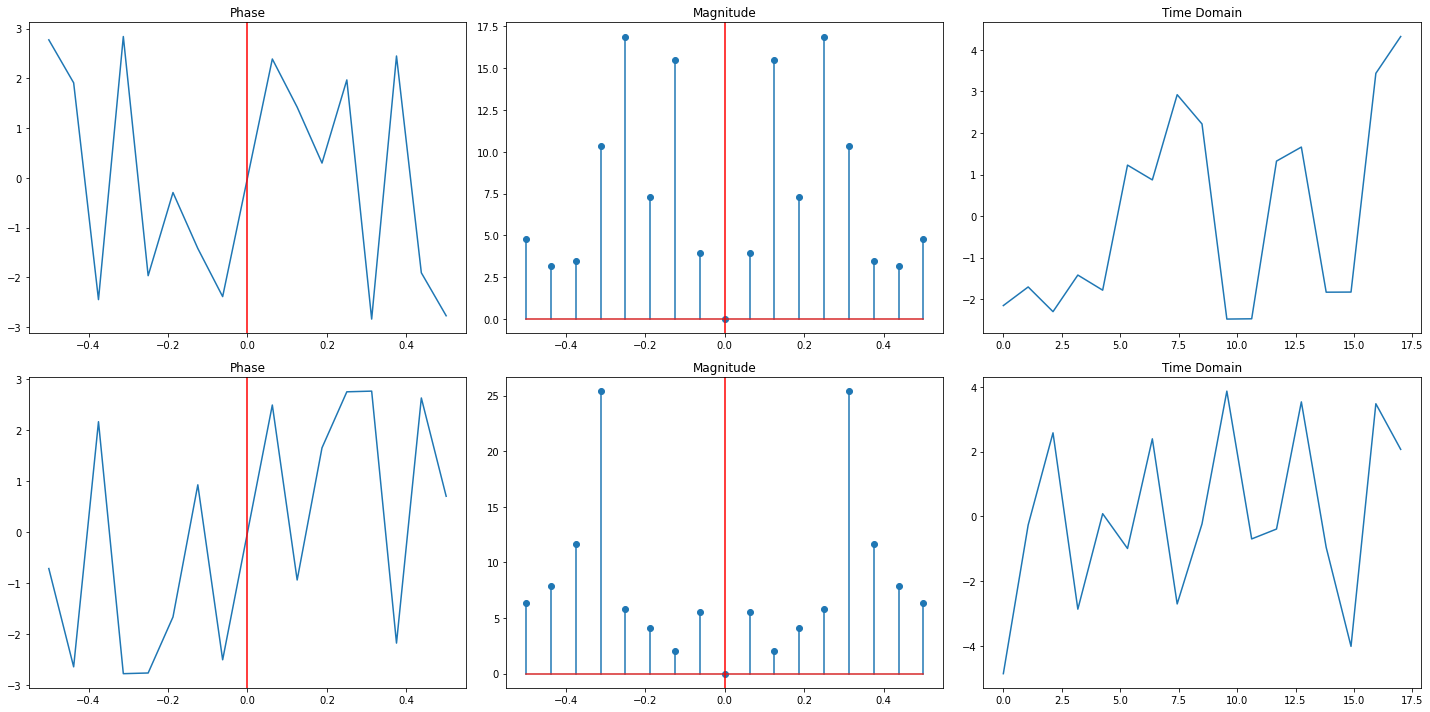

In [5]:
# Plot 
# Three at random
samples = 2
B = int(length_of_signals//2)
vals = np.random.randint(0,amount_of_signals,samples)

fig, axs = plt.subplots(samples,3,figsize=(samples*2*5,5*samples))
for i in range(samples):
    idx = int(vals[i])
    phase = np.angle(spectra[idx,:])
    magnitude = np.real(np.abs(spectra[idx,:]))

    axs[i,0].set_title('Phase')
    axs[i,0].plot(np.linspace(-0.5,0.5,length_of_signals),phase)
    axs[i,0].axvline(x=0,color='r')

    axs[i,1].set_title('Magnitude')
    axs[i,1].stem(np.linspace(-0.5,0.5,length_of_signals),magnitude)
    axs[i,1].axvline(x=0,color='r')


    axs[i,2].set_title('Time Domain')
    axs[i,2].plot(np.linspace(0,length_of_signals,length_of_signals),signals[idx,:])
plt.tight_layout()
plt.show()

/home/ottersome/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

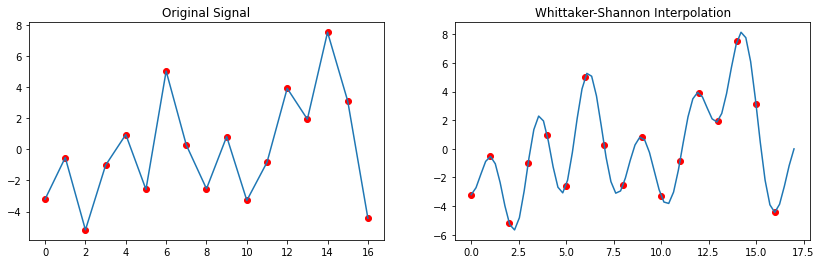

In [11]:
# Actually do the dataset
up_t = np.linspace(0,signals.shape[1],4*signals.shape[1])
y_true_np = np.array([sinc_interp(signal,1,up_t) for signal in signals])

## Example
signal = np.real(signals[0,:])

upsampled = y_true_np[0]

fig, axs  = plt.subplots(1,2,figsize=(14,4))
axs[0].set_title('Original Signal')
axs[0].plot(np.arange(len(signal)),signal)
axs[0].scatter(np.arange(len(signal)),signal,color='r')

axs[1].set_title('Whittaker-Shannon Interpolation')
axs[1].plot(up_t,upsampled)
axs[1].scatter(np.arange(len(signal)),signal,color='r')
plt.plot()

# Machine Learning

In [12]:
from samprecon.reconstructors.NNReconstructors import WideNN as WideNet
import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm

In [14]:
wide_criterion = nn.MSELoss()

wideModel = WideNet(length_of_signals,4*length_of_signals)
wide_optim = optim.Adam(wideModel.parameters(), lr=0.001)

x = torch.Tensor(np.real(signals).astype(np.float32))
y_true = torch.tensor(y_true_np.astype(np.float32))
epoch_meter = tqdm(total=50, desc='Epoch Training Loss')
for epoch in range(50):
    wide_optim.zero_grad()
    y_inf = wideModel(x)
    loss = wide_criterion(y_inf, y_true)
    loss.backward()
    wide_optim.step()
    epoch_meter.set_description(f"Epoch {epoch+1}/50, Loss {loss.item():.4f}")
    epoch_meter.update(1)
epoch_meter.close()



<ipython-input-14-c3c66b9b924b>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  y_true = torch.tensor(y_true_np.astype(np.float32))
Epoch 2/50, Loss 10.0528:   2%|▏         | 1/50 [00:00<00:01, 28.66it/s]

Epoch 50/50, Loss 0.1630: 100%|██████████| 50/50 [00:00<00:00, 52.89it/s]


In [ ]:
# Validate
wideMode.eval()

# Actually do the dataset
up_t = np.linspace(0,signals.shape[1],4*signals.shape[1])
#y_true_np = np.array([sinc_interp(signal,1,up_t) for signal in signals])
ridx = np.random.randint(0,signals.shape[0],3)
print('Random indices are : '+str(ridx))

## Example
real_sigs = np.real(signals[ridx,:])
ground_truth = np.array([sinc_interp(sig) for sig in real_sigs])
val_sigs = torch.Tensor(real_sigs)
val_recs = wideModel(val_sigs).numpy()


upsampled = y_true_np[0]

fig, axs  = plt.subplots(3,3,figsize=(14,14))
for i in range(3):
    og_sig = real_sigs[i,:]
    gtruth = ground_truth[i,:]
    infRecon = val_recs[i,:]

    axs[i,0].set_title('Original Signal')
    axs[i,0].plot(np.arange(len(og_sig)),og_sig)
    axs[i,0].scatter(np.arange(len(og_sig)),og_sig,color='r')

    axs[i,1].set_title('Inferece')
    axs[i,1].plot(up_t,gtruth)
    axs[i,1].scatter(np.arange(len(signal)),signal,color='r')
    
    axs[i,2].set_title('Whittaker-Shannon Interpolation')
    axs[i,2].plot(up_t,infRecon)
    axs[i,2].scatter(np.arange(len(signal)),signal,color='r')
    plt.plot()
